In [1]:
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
# from scipy.spatial.distance import pdist

# import kernel thinning
from goodpoints import kt # kt.thin is the main thinning function; kt.split and kt.swap are other important functions
from goodpoints.tictoc import tic, toc # for timing blocks of code


# utils for generating samples, evaluating kernels, and mmds
from util_k_mmd import kernel_eval

# for partial functions, to use kernel_eval for kernel
from functools import partial

In [3]:
import openturns as ot
import matplotlib.pyplot as plt

In [2]:
1e-16 * 1e-16

9.999999999999999e-33

In [34]:
modes = [ot.Normal(0.3, 0.12), ot.Normal(0.7, 0.1)]
weight = [0.4, 1.0]
mixture = ot.Mixture(modes, weight)
X1 = ot.TruncatedDistribution(mixture, 0., 1.)
X1.setDescription(["X1"])
X2 = ot.TruncatedDistribution(ot.Normal(0.6, 0.15), 0., 1.)
X2.setDescription(["X2"])
myDistribution = ot.ComposedDistribution([X1, X2], ot.ClaytonCopula(2.))
candidate_points = np.array(myDistribution.getSample(2**12))

In [35]:
var = 1. # Variance
d = int(2)

params_k_swap = {"name": "gauss", "var": var, "d": int(d)}
params_k_split = {"name": "gauss_rt", "var": var/2., "d": int(d)}

split_kernel = partial(kernel_eval, params_k=params_k_split)
swap_kernel = partial(kernel_eval, params_k=params_k_swap)

In [52]:
from goodpoints import kt
coreset = kt.thin(candidate_points, 8, split_kernel, swap_kernel, delta=0.5, seed=123, store_K=False, 
                  verbose=False)
n = len(coreset)
coreset

array([3312, 3810, 3272,  436, 1985, 2187,   73, 1346,  357, 2378, 2776,
       2832, 3125, 3332, 3606, 3713])

In [53]:
import otkerneldesign as otkd
dimension = myDistribution.getDimension()

# Kernel definition
ker_list = [ot.MaternModel([0.1], [1.0], 2.5)] * dimension
kernel = ot.ProductCovarianceModel(ker_list)
# Kernel herding design
kh = otkd.KernelHerding(
    kernel=kernel,
    candidate_set_size=2 ** 12,
    distribution=myDistribution
)
kh_design, _ = kh.select_design(n)

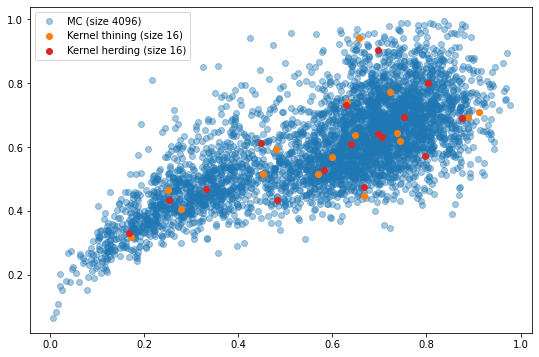

In [54]:
fig = plt.figure(figsize=(9, 6))
plt.scatter(candidate_points[:, 0], candidate_points[:, 1], label="MC (size 4096)", alpha=0.4)
plt.scatter(candidate_points[coreset, 0], candidate_points[coreset, 1], label="Kernel thining (size {})".format(n))
plt.scatter(kh_design[:, 0], kh_design[:, 1], label="Kernel herding (size {})".format(n), color='C3')
plt.legend();